**In this script, it was aimed to apply cluster analysis (by kmeans) on the data obtained as standard deaths rates from cardiovascular issues. The country lists placed in each cluster were looked in, and also the resulting data were shown on a map. The clusters were sorted by the levels, to aid in visual representations easier to view.** 

* Step 1: Load cleaned deaths data (Table 1)
* Step 2: Select features for clustering (SDR_total, SDR_male, SDR_female)
* Step 3: Standardize features
* Step 4: Apply kmeans clustering
* Step 5: Summarize clusters (country lists and mean SDRs)
* Step 6: Visualize clusters with diagonal KDE plots
* Step 7: Assign qualitative labels to clusters
* Step 8: Save clustered data to Excel
* Step 9: European map visualization 

Cluster means (SDR values):
          SDR_total     SDR_male  SDR_female
Cluster                                     
0        261.032273   312.808182  219.557273
1        547.716667   661.400000  465.846667
2        790.600000   965.145000  673.087500
3        999.400000  1226.755000  839.045000

Countries per cluster:

Cluster 0:
['EU', 'Belgium', 'Denmark', 'Germany', 'Ireland', 'Greece', 'Spain', 'France', 'Italy', 'Cyprus', 'Luxembourg', 'Malta', 'Netherlands', 'Austria', 'Portugal', 'Slovenia', 'Finland', 'Sweden', 'Iceland', 'Liechtenstein', 'Norway', 'Switzerland']

Cluster 1:
['Czechia', 'Estonia', 'Croatia', 'Poland', 'Slovakia', 'Türkiye']

Cluster 2:
['Latvia', 'Lithuania', 'Hungary', 'Serbia']

Cluster 3:
['Bulgaria', 'Romania']


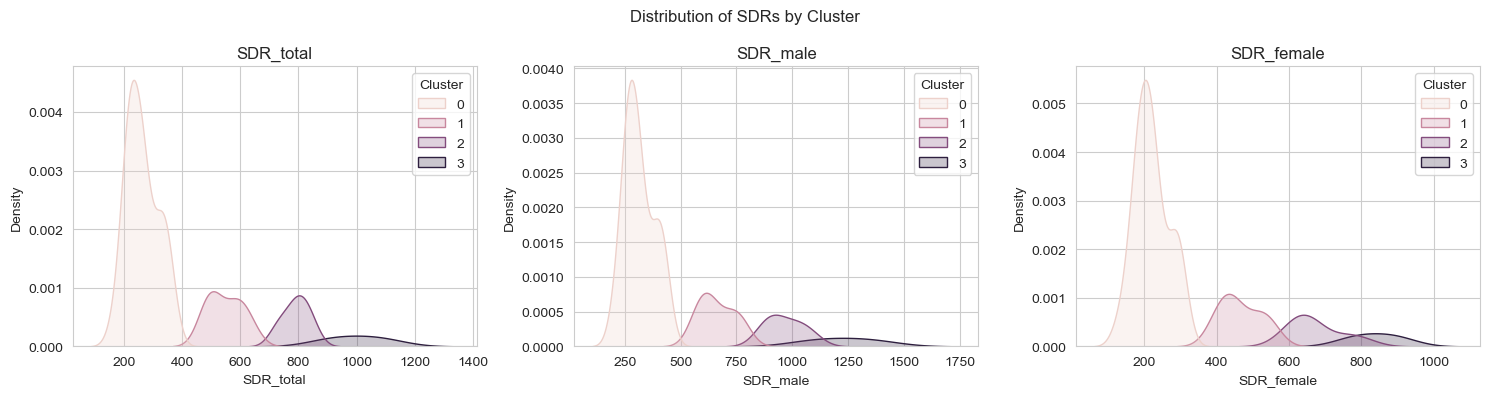


Cluster labels assigned:
          Country  Cluster Cluster_Label
0              EU        0           Low
1         Belgium        0           Low
2        Bulgaria        3     Very High
3         Czechia        1        Medium
4         Denmark        0           Low
5         Germany        0           Low
6         Estonia        1        Medium
7         Ireland        0           Low
8          Greece        0           Low
9           Spain        0           Low
10         France        0           Low
11        Croatia        1        Medium
12          Italy        0           Low
13         Cyprus        0           Low
14         Latvia        2          High
15      Lithuania        2          High
16     Luxembourg        0           Low
17        Hungary        2          High
18          Malta        0           Low
19    Netherlands        0           Low
20        Austria        0           Low
21         Poland        1        Medium
22       Portugal        0     

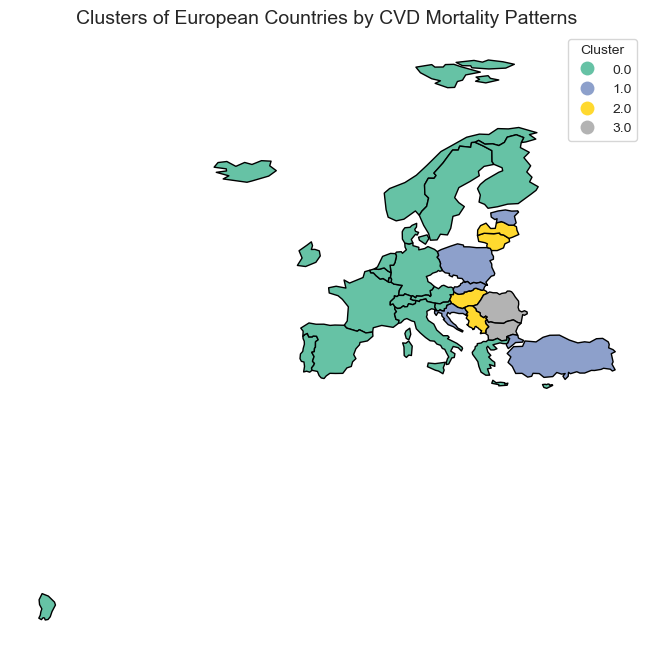

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import geopandas as gpd

df = pd.read_csv("data/processed/deaths_clean.csv")

features = ["SDR_total", "SDR_male", "SDR_female"]
data = df[features].copy()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)


kmeans = KMeans(n_clusters=4, random_state=42)
df["Cluster"] = kmeans.fit_predict(data_scaled)


cluster_order = df.groupby("Cluster")["SDR_total"].mean().sort_values().index
cluster_mapping = {old: new for new, old in enumerate(cluster_order)}
df["Cluster"] = df["Cluster"].map(cluster_mapping)

summary = df.groupby("Cluster")[features].mean()
print("Cluster means (SDR values):")
print(summary)

print("\nCountries per cluster:")
for c in sorted(df["Cluster"].unique()):
    print(f"\nCluster {c}:")
    print(df[df["Cluster"] == c]["Country"].tolist())

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(features):
    sns.kdeplot(data=df, x=col, hue="Cluster", fill=True, ax=axes[i])
    axes[i].set_title(col)
plt.suptitle("Distribution of SDRs by Cluster")
plt.tight_layout()
plt.show()

labels = ["Low", "Medium", "High", "Very High"]
cluster_means = df.groupby("Cluster")["SDR_total"].mean().sort_values()
cluster_label_mapping = {cluster: label for cluster, label in zip(cluster_means.index, labels)}
df["Cluster_Label"] = df["Cluster"].map(cluster_label_mapping)

print("\nCluster labels assigned:")
print(df[["Country", "Cluster", "Cluster_Label"]])

df.to_excel("data/processed/deaths_clustered.xlsx", index=False)
print("\nClustered data saved to 'data/processed/deaths_clustered.xlsx'")

world = gpd.read_file(
    "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
)

europe = world[world["CONTINENT"].isin(["Europe", "Asia"])].copy()
europe.rename(columns={"NAME": "Country"}, inplace=True)

df["Country"] = df["Country"].replace({
    "Türkiye": "Turkey",
    "Czechia": "Czech Republic",
    "North Macedonia": "North Macedonia"
})

merged = europe.merge(df, on="Country", how="left")

fig, ax = plt.subplots(figsize=(10, 8))
merged.plot(
    column="Cluster",
    categorical=True,
    cmap="Set2",
    legend=True,
    ax=ax,
    edgecolor="black"
)
ax.set_title("Clusters of European Countries by CVD Mortality Patterns", fontsize=14)
ax.axis("off")

leg = ax.get_legend()
leg.set_title("Cluster")
plt.show()